# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'data/train.p'
validation_file = 'data/valid.p'
testing_file    = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print("Data loaded")

Data loaded


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]

# TODO: How many unique classes/labels there are in the dataset.
all_labels = np.concatenate((y_train, y_valid, y_test))
n_classes = len(np.unique(all_labels))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

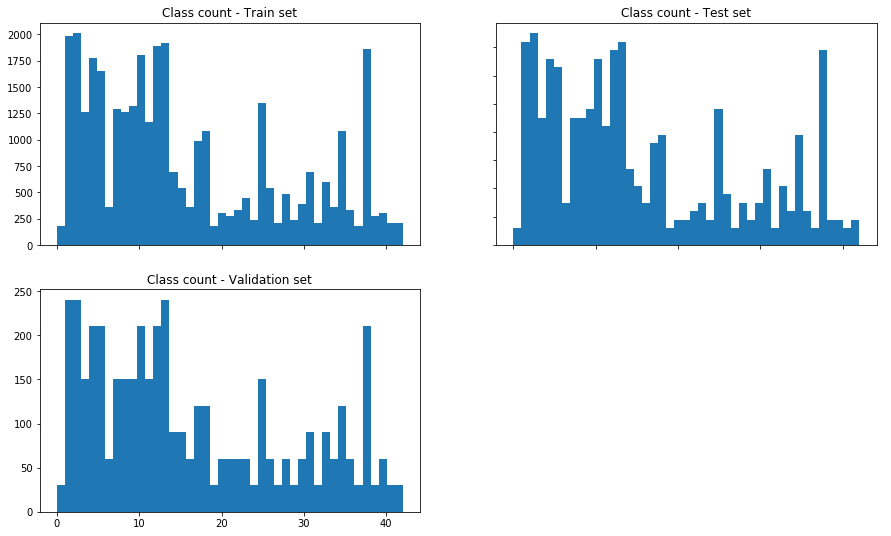

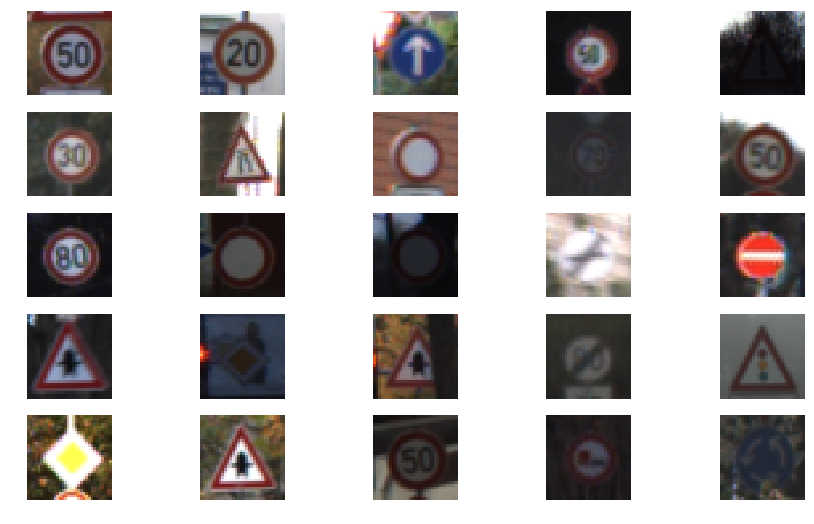

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from random import *
# Visualizations will be shown in the notebook.
%matplotlib inline
fig_size = [None] * 2
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

### Class distribution
numbins = n_classes
f, axarr = plt.subplots(2, 2)
axarr[0, 0].hist(y_train, numbins)
axarr[0, 0].set_title('Class count - Train set')
axarr[0, 1].hist(y_test, numbins)
axarr[0, 1].set_title('Class count - Test set')
axarr[1, 0].hist(y_valid, numbins)
axarr[1, 0].set_title('Class count - Validation set')
axarr[1, 1].axis('off')
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.show()


### Image examples
ncols = 5
nrows = 5
sample_idx = sample(range(n_train), ncols*nrows)
count = 0
f, axarr = plt.subplots(nrows, ncols)
for idx in sample_idx:
    r = count % nrows
    c = int(count / nrows)
    axarr[r, c].imshow(X_train[idx,])
    axarr[r, c].axis('off')
    count += 1

plt.show()


## Data Augmentations and Class Re-Balancing

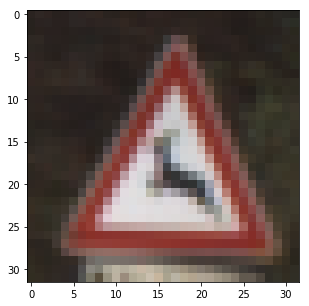

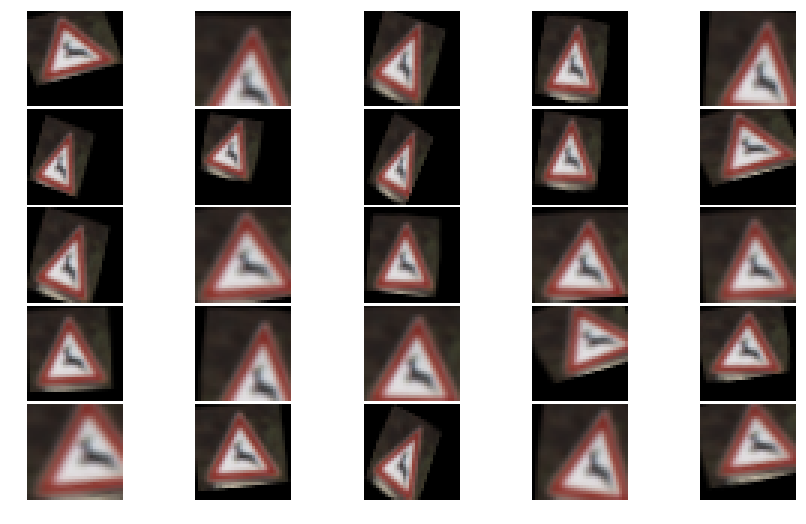

In [4]:
import cv2


def random_affine(image):
    # Add random image transformations: zoom, affine. 
    # Avoid flipping ud and lr because the direction of arrows and orientation of signs are significant
    # Brightness and contrast are insignificant because we will be doing histogram equalization later
    height, width = image.shape[0:2]
    
    max_angle = 20
    angle = max_angle *  random() - max_angle/2
    rotation = cv2.getRotationMatrix2D((height/2, width/2), angle, 1)
    transformed = cv2.warpAffine(image, rotation, (width,height))
    
    max_translation = 5
    dx = max_translation * random() - max_translation/2
    dy = max_translation * random() - max_translation/2
    translation = np.float32([[1,0,dx],[0,1,dy]])
    transformed = cv2.warpAffine(transformed, translation, (width,height))
    
    max_shear = 10
    input_points = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5 + max_shear * random() - max_shear/2
    pt2 = 20 + max_shear * random() - max_shear/2
    output_points = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear = cv2.getAffineTransform(input_points, output_points)
    transformed = cv2.warpAffine(transformed, shear, (width,height))
    
    return transformed
    


def augment_class(data, factor):
    
    data_aug = data.tolist()
    n_examples = data.shape[0]
    i = 0
    
    while len(data_aug) < n_examples * factor:
        j = i % n_examples
        newimage = random_affine(data[j, :, :, :])
        data_aug.append(newimage)
        i += 1
    
    return data_aug



original = X_train[500,]
plt.figure(figsize=(5,5))
plt.imshow(original)
plt.show()

ncols = 5
nrows = 5
count = 0
f, axarr = plt.subplots(nrows, ncols)
for i in range(ncols*nrows):
    r = i % nrows
    c = int(i / nrows)
    newim = random_affine(original)
    axarr[r, c].imshow(newim)
    axarr[r, c].axis('off')
    plt.subplots_adjust(wspace = 0.03, hspace = .03)

plt.show()


Performing Data Augmentations


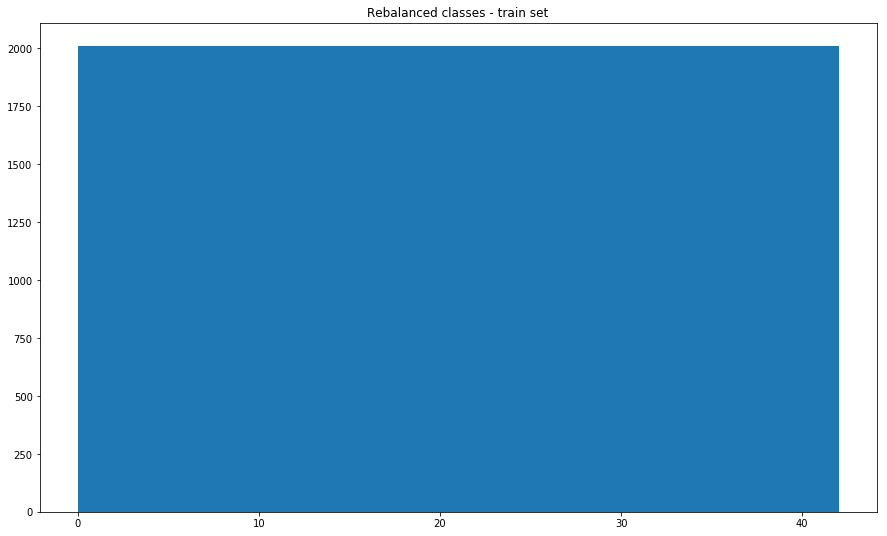

In [5]:

### Calculate prob of class occurrence and rebalancing factor 
h, bins = np.histogram(y_train, range(numbins+1))
max_occurrence = h.max()
prob_occurrence = h / max_occurrence
rebalance_factor = 1.0 / prob_occurrence

### Create augmented training set
# Use python lists for efficiency
X_train_aug = []
y_train_aug = []

print("Performing Data Augmentations")

for c in range(numbins):
    class_idx = np.where(y_train == c)
    class_data = X_train[class_idx]
    aug_class_data = augment_class(class_data, rebalance_factor[c])
    X_train_aug = X_train_aug + aug_class_data
    y_train_aug = y_train_aug + [c] * len(aug_class_data)

# Convert back to numpy arrays
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)


### Show new histogram for training data
plt.hist(y_train_aug, numbins)
plt.title('Rebalanced classes - train set')
plt.show()



## Preprocessing the Data

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:

def histogram_equalization(image):
    output = image.copy()
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)
    output[:, :, 2] = cv2.equalizeHist(output[:, :, 2])
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    return output

def converto_to_uint8(image):
    """
    Convert float32 image to uint8 and scale values to [0, 255]
    """
    a = 0.0
    b = 255.0
    dmin = np.min(image)
    dmax = np.max(image)
    newimage = a + (image - dmin)*(b-a)/(dmax - dmin)
    return np.uint8(newimage)

def sharpen(image):
    imagef = np.float32(image)
    smooth = cv2.GaussianBlur(imagef, (5,5), 0)
    weighted = cv2.addWeighted(imagef, 2, smooth, -1, 0)
    return converto_to_uint8(weighted)

def preprocess_image(image):
    output = sharpen(image)
    output = histogram_equalization(output)
    return normalize_image(output)

def preprocess_set(image_set):
    preprocessed = np.empty(shape=image_set.shape, dtype=np.float32)
    for i in range(image_set.shape[0]):
        preprocessed[i,] = preprocess_image(image_set[i,])
        
    return preprocessed

def normalize_image(image):
    imagef32 = np.float32(image)
    a = -.5
    b = .5
    dmin = np.min(imagef32)
    dmax = np.max(imagef32)
    newimage = a + (imagef32 - dmin)*(b-a)/(dmax - dmin)
    return newimage

Before preprocessing


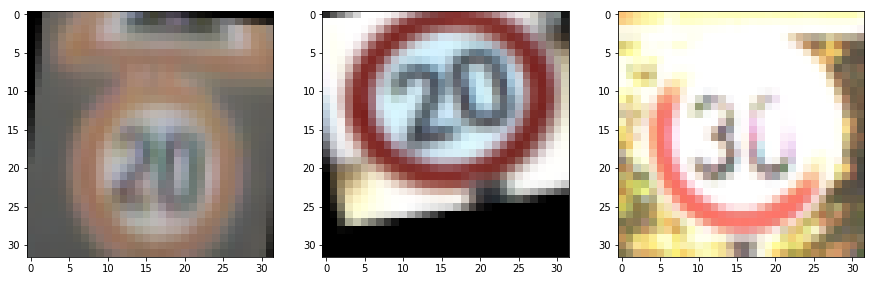

Preprocessing the data
Data processed
float32


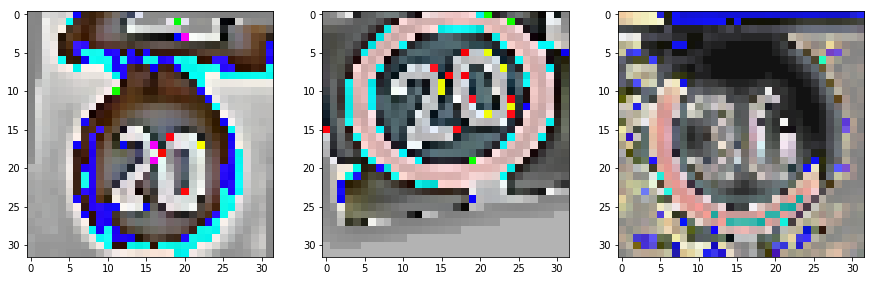

In [7]:
from sklearn.utils import shuffle

print("Before preprocessing")
indeces = [1000, 2000, 3000]
f, axarr = plt.subplots(1, 3)
for i in range(len(indeces)):
    im = X_train_aug[indeces[i]]
    axarr[i].imshow(np.uint8(im))
plt.show()

print("Preprocessing the data")
X_train_aug = preprocess_set(X_train_aug)
X_valid = preprocess_set(X_valid)
X_test = preprocess_set(X_test)


X_train, y_train = shuffle(X_train_aug, y_train_aug)

print("Data processed")
print(X_train_aug.dtype)
f, axarr = plt.subplots(1, 3)
for i in range(len(indeces)):
    axarr[i].imshow(X_train_aug[indeces[i]])
plt.show()

## Save the Augmented and Preprocessed Data

In [8]:
### Save the new set in another file
import os


def save_to_file(filename, X, y):
    if not os.path.isfile(filename):
        print('Saving data to pickle file ', filename)
        try:
            with open(filename, 'wb') as pfile:
                pickle.dump(
                {
                    'features': X,
                    'labels': y
                },
                pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
            raise

training_file   = 'data/pp_train.p'
validation_file = 'data/pp_valid.p'
testing_file    = 'data/pp_test.p'
save_to_file(training_file, X_train, y_train)
save_to_file(validation_file, X_valid, y_valid)
save_to_file(testing_file, X_test, y_test)



print('Data saved in pickle files.')

Data saved in pickle files.


## Reload the data

In [ ]:
# Load pickled data
import pickle


training_file   = 'data/pp_train.p'
validation_file = 'data/pp_valid.p'
testing_file    = 'data/pp_test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('All data loaded from pickle files.')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Model Architecture

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 15
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def MyNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 0: Convolutional. Input = 32x32x3. Output = 32x32xd0.
    d0 = 32
    layer0w = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, d0), mean=mu, stddev=sigma))
    layer0b = tf.Variable(tf.zeros(shape=(d0)))
    layer0o = tf.nn.conv2d(x, layer0w, strides=[1, 1, 1, 1], padding='SAME') + layer0b
    layer0a = tf.nn.relu(layer0o)
    
    # Layer 1: Convolutional. Input = 32x32xd0. Output = 32x32xd1.
    d1 = d0
    layer1w = tf.Variable(tf.truncated_normal(shape=(3, 3, d0, d1), mean=mu, stddev=sigma))
    layer1b = tf.Variable(tf.zeros(shape=(d1)))
    layer1o = tf.nn.conv2d(layer0a, layer1w, strides=[1, 1, 1, 1], padding='SAME') + layer1b
    layer1a = tf.nn.relu(layer1o)
    layer1a = tf.nn.dropout(layer1a, keep_prob)

    # Pooling. Input = 32x32xd1. Output = 16x16xd1.
    layer1p = tf.nn.max_pool(layer1a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 16x16xd1. Output = 16x16xd2.
    d2 = 2 * d1
    layer2w = tf.Variable(tf.truncated_normal(shape=(3, 3, d1, d2), mean=mu, stddev=sigma))
    layer2b = tf.Variable(tf.zeros(shape=(d2)))
    layer2o = tf.nn.conv2d(layer1p, layer2w, strides=[1, 1, 1, 1], padding='SAME') + layer2b
    layer2a = tf.nn.relu(layer2o)
    layer2a = tf.nn.dropout(layer2a, keep_prob)

    # Pooling. Input = 16x16xd2. Output = 8x8xd2.
    layer2p = tf.nn.max_pool(layer2a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 3: Convolutional. Input = 8x8xd2. Output = 8x8xd3.
    d3 = 2 * d2
    layer3w = tf.Variable(tf.truncated_normal(shape=(3, 3, d2, d3), mean=mu, stddev=sigma))
    layer3b = tf.Variable(tf.zeros(shape=(d3)))
    layer3o = tf.nn.conv2d(layer2p, layer3w, strides=[1, 1, 1, 1], padding='SAME') + layer3b
    layer3a = tf.nn.relu(layer3o)
    layer3a = tf.nn.dropout(layer3a, keep_prob)

    # Pooling. Input = 8x8xd3. Output = 4x4xd3.
    layer3p = tf.nn.max_pool(layer3a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 4x4xd3. Output = 4*4*d3.
    layer3f = flatten(layer3p)
    
    # Layer 4: Fully Connected. Input = 4*4*d3. Output = 2*2*d3.
    layer4w = tf.Variable(tf.truncated_normal(shape=(4*4*d3, 2*2*d3), mean=mu, stddev=sigma))
    layer4b = tf.Variable(tf.zeros(2*2*d3))
    layer4o = tf.matmul(layer3f, layer4w) + layer4b
    
    # Activation.
    layer4a = tf.nn.relu(layer4o)

    # Layer 5: Fully Connected. Input = 2*2*d3. Output = 2*2*d3.
    layer5w = tf.Variable(tf.truncated_normal(shape=(2*2*d3, 2*2*d3), mean=mu, stddev=sigma))
    layer5b = tf.Variable(tf.zeros(2*2*d3))
    layer5o = tf.matmul(layer4a, layer5w) + layer5b
    
    # Activation.
    layer5a = tf.nn.relu(layer5o)

    # Layer 6: Fully Connected. Input = 2*2*d3. Output = 43.
    layer6w = tf.Variable(tf.truncated_normal(shape=(2*2*d3, 43), mean=mu, stddev=sigma))
    layer6b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(layer5a, layer6w) + layer6b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Features and Labels

In [10]:

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

#### Training Pipeline

In [11]:
rate = 0.001

logits = MyNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


#### Training the Model

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_t, y_t = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_t[offset:end], y_t[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './mynet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.830

EPOCH 2 ...
Validation Accuracy = 0.905

EPOCH 3 ...
Validation Accuracy = 0.914

EPOCH 4 ...
Validation Accuracy = 0.919

EPOCH 5 ...
Validation Accuracy = 0.939

EPOCH 6 ...
Validation Accuracy = 0.930

EPOCH 7 ...
Validation Accuracy = 0.935

EPOCH 8 ...
Validation Accuracy = 0.939

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.937

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.956

EPOCH 13 ...
Validation Accuracy = 0.941

EPOCH 14 ...
Validation Accuracy = 0.944

EPOCH 15 ...
Validation Accuracy = 0.944

Model saved


#### Evaluating the Model

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))

Test Accuracy = 0.930
Train Accuracy = 0.996


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
# Re-import necessary libraries, used for resuming work after kernel was shut down
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Visualizations will be shown in the notebook.
%matplotlib inline
fig_size = [None] * 2
fig_size[0] = 15
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

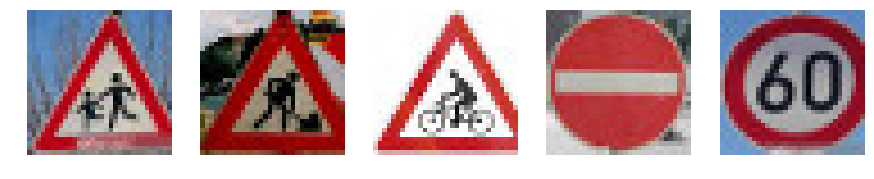

In [21]:
def standarize_image(filename):
    image = cv2.imread(filename)
    image = image[:32, :32, :]
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

filenames = os.listdir("newimages/")
newimages = [standarize_image("newimages/"+ name) for name in filenames]

ncols = 5
nrows = 1
f, axarr = plt.subplots(nrows, ncols)
for c in range(ncols):
    axarr[c].imshow(newimages[c])
    axarr[c].axis('off')
    plt.subplots_adjust(hspace = .03)

plt.show()

preprocessed = []
for im in newimages: 
    preprocessed.append(preprocess_image(im))
    

### Predict the Sign Type for Each Image

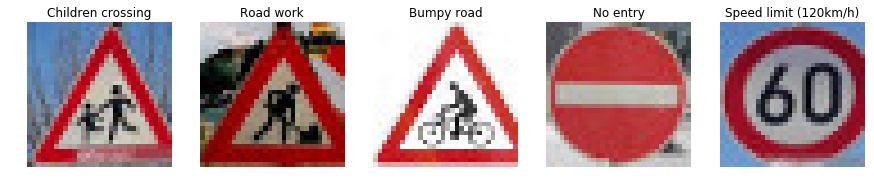

In [22]:
## Get the class names from the CSV file
import csv

class_names = []
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        class_names.append((row['SignName']))
        

def make_prediction(data):
    sess = tf.get_default_session()
    prediction = sess.run(tf.argmax(logits, 1), feed_dict={x: data, keep_prob: 1.0})
    return prediction

## Print the prediction for each image 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = make_prediction(preprocessed)

ncols = 5
nrows = 1
f, axarr = plt.subplots(nrows, ncols)
for c in range(ncols):
    axarr[c].imshow(newimages[c])
    axarr[c].axis('off')
    axarr[c].set_title(class_names[prediction[c]])
    plt.subplots_adjust(hspace = .03)

plt.show()

### Analyze Performance

In [23]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
ground_truth = [28, 25, 29, 17, 3]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    accuracy = sess.run(accuracy_operation, feed_dict={x: preprocessed, y: ground_truth, keep_prob: 1.0})
    print("New Images Accuracy = {:.3f}".format(accuracy))

New Images Accuracy = 0.600


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 


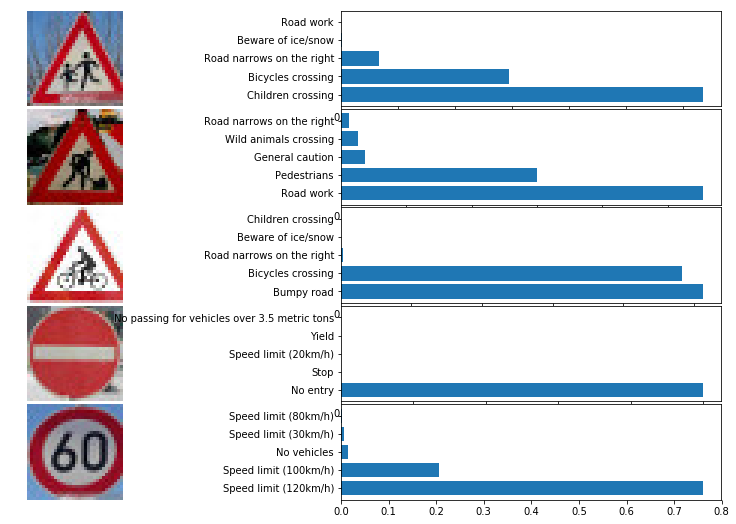

In [24]:

softmax_prob = tf.nn.softmax(logits)
top5 = tf.nn.top_k(softmax_prob, k=5)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_prob = sess.run(top5, feed_dict={x: preprocessed, keep_prob: 1.0})

ncols = 2
nrows = 5
y_pos = range(5)
f, axarr = plt.subplots(nrows, ncols)
for c in range(nrows):
    axarr[c, 0].imshow(newimages[c])
    axarr[c, 0].axis('off')
    axarr[c, 1].barh(y_pos, top5_prob.values[c])
    axarr[c, 1].set_yticks(y_pos)
    labels = [class_names[j] for j in top5_prob.indices[c]]
    axarr[c, 1].set_yticklabels(labels)
    plt.subplots_adjust(hspace = .03)

plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.